In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((244, 244)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='./imgs/training_set', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [3]:
trainset.classes

['cats', 'dogs']

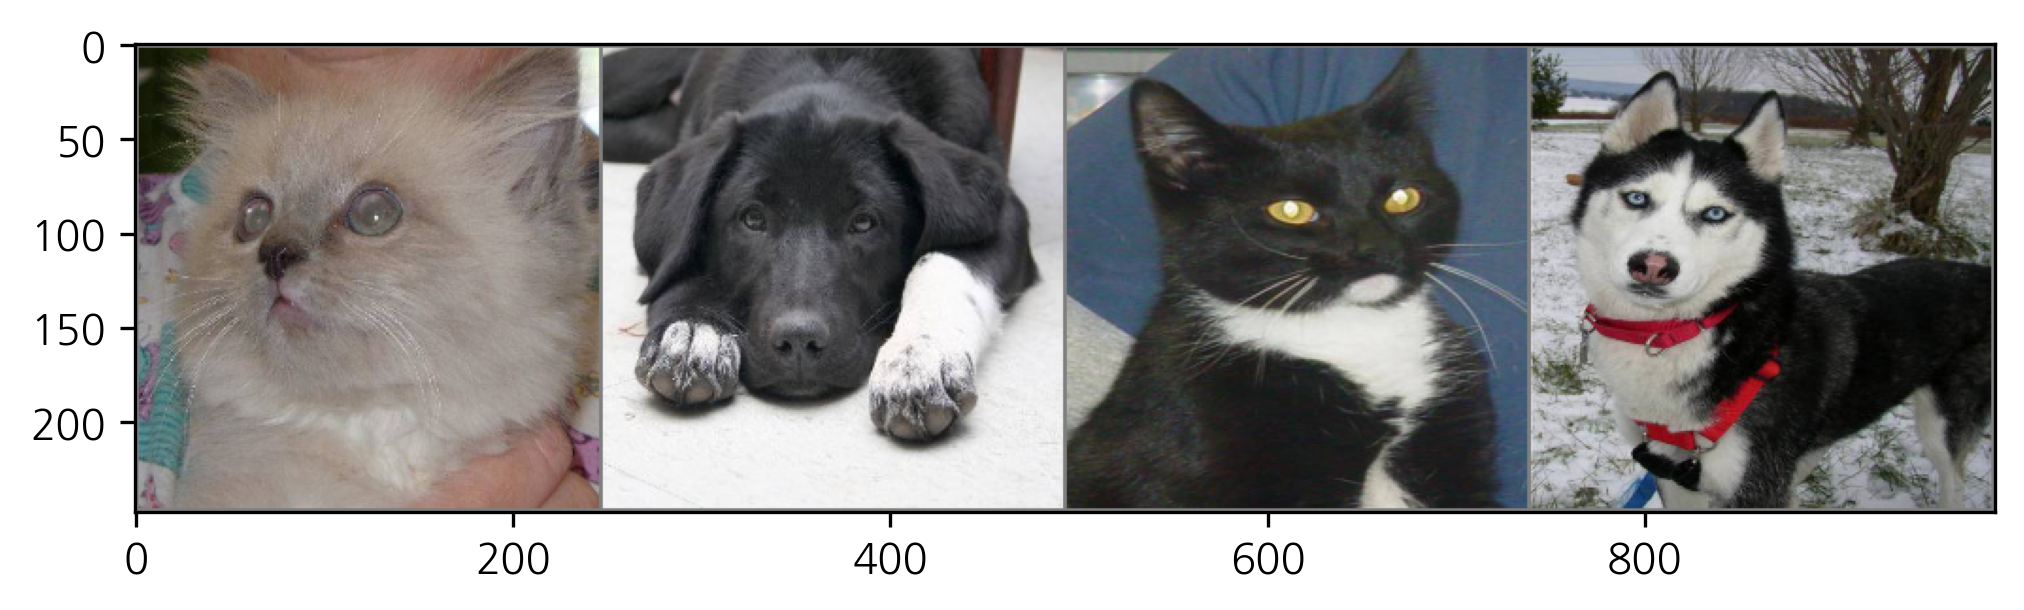

cats  dogs  cats  dogs 


In [4]:
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
model = models.mobilenet_v2()
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
model = models.mobilenet_v2(pretrained=True)


num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 2), # 2차원으로 매핑
    nn.Sigmoid()  # Use sigmoid activation for binary classification
)

print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2, bias=True)
  (1): Sigmoid()
)


In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)




epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        labels_one_hot = torch.zeros(labels.size(0), 2).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1) # dim = 1 가로방향, labels.unsqueeze(1) 위치에, 1 넣기

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("Training finished.")

[1,  2000] loss: 0.567
[2,  2000] loss: 0.540
[3,  2000] loss: 0.536
[4,  2000] loss: 0.533
[5,  2000] loss: 0.531
[6,  2000] loss: 0.528
[7,  2000] loss: 0.526
[8,  2000] loss: 0.524
[9,  2000] loss: 0.524
[10,  2000] loss: 0.524
Training finished.


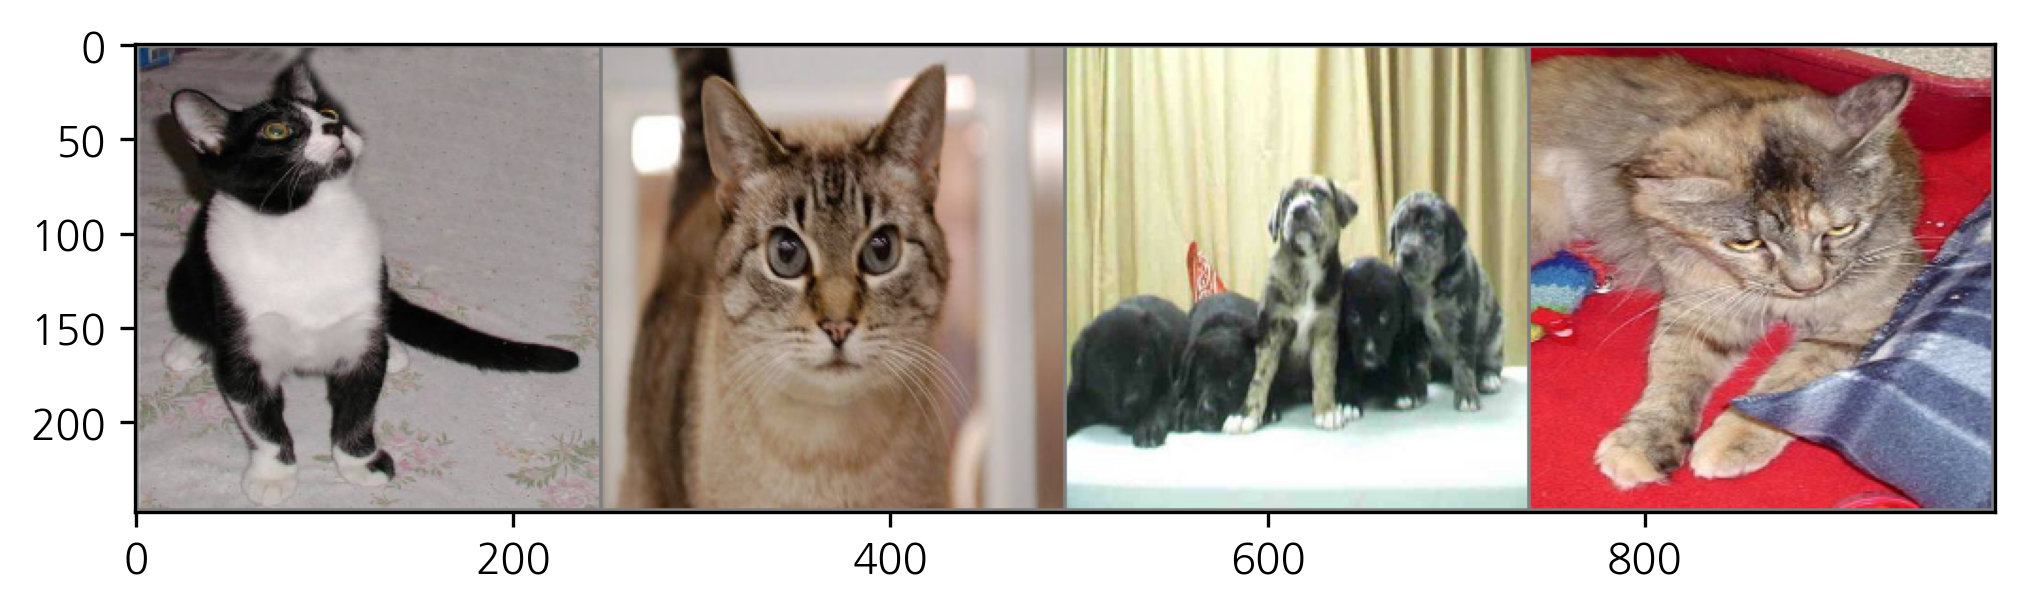

GroundTruth:  cats  cats  dogs  cats 


In [15]:
testset = torchvision.datasets.ImageFolder(root='./imgs/test_set', transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{testset.classes[labels[j]]:5s}' for j in range(4)))

In [10]:
PATH = './CatandDog_MobileNetV2.pth'
torch.save(model.state_dict(), PATH)

In [20]:
## CUDA 기기가 존재한다면, CUDA 장치를 출력:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Convert labels to one-hot encoded format
        labels_one_hot = torch.zeros(labels.size(0), 2).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
        
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images)
        
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels_one_hot.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

cuda:0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor